### Проект: вариант 1
### Задание 1
####  Retention – один из самых важных показателей в компании.  Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
from operator import attrgetter
import matplotlib.colors as mcolors

#### Создаем функцию для Retention

In [2]:
def retention(reg_data_url, auth_data_url, first_day, last_day):
    
    # Загружаем данные
    reg_data = pd.read_csv(reg_data_url, sep=';')
    auth_data = pd.read_csv(auth_data_url, sep=';')
    
    # Мерждим две таблицы
    all_data = reg_data.merge(auth_data, how='left', on='uid')
    
    # Сбарсываем дубликаты и пропуски
    all_data = all_data.drop_duplicates().dropna()
    
    # Преобразовываем даты в нормальный вид
    all_data['reg_ts'] = pd.to_datetime(all_data.reg_ts, unit='s').dt.date
    all_data['auth_ts'] = pd.to_datetime(all_data.auth_ts, unit='s').dt.date
    
    # Создаем возможность задавать нужный интервал даты
    all_data = all_data[(all_data.reg_ts >= pd.to_datetime(first_day)) & (all_data.auth_ts <= pd.to_datetime(last_day))]
    
    # Объединяем данные по когорте и захода пользователей в игру за день 
    # и подсчитываем количество уникальных клиентов в каждой группе. 
    # Добавляем число_периода, которое указывает количество периодов между днем когорты и днем захода.
    df_cohort = all_data.groupby(['reg_ts', 'auth_ts']) \
                        .agg(n_customers=('uid', 'nunique')) \
                        .reset_index(drop=False)
    df_cohort['period_number'] = (df_cohort.auth_ts - df_cohort.reg_ts).apply(attrgetter('days'))
    
    # Используя pivot  поворачиваем таблицу df_cohort таким образом, чтобы каждая строка содержала информацию 
    # о данной когорте, а каждый столбец содержал значения за определенный период.
    cohort_pivot = df_cohort.pivot_table(index='reg_ts',
                                         columns='period_number',
                                         values='n_customers')

    # Чтобы получить матрицу удержания, нам нужно разделить значения каждой строки на первое значение строки, 
    # которое на самом деле является размером когорты — все клиенты, которые сделали свою первый заход в игру.
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

    # Визуализация
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(18, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.1%', 
                    cmap='RdYlGn', 
                    ax=ax[1])
        ax[1].set_title('Daily Cohorts: User Retention', fontsize=16)
        ax[1].set(xlabel='№ of periods',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()
        
        return

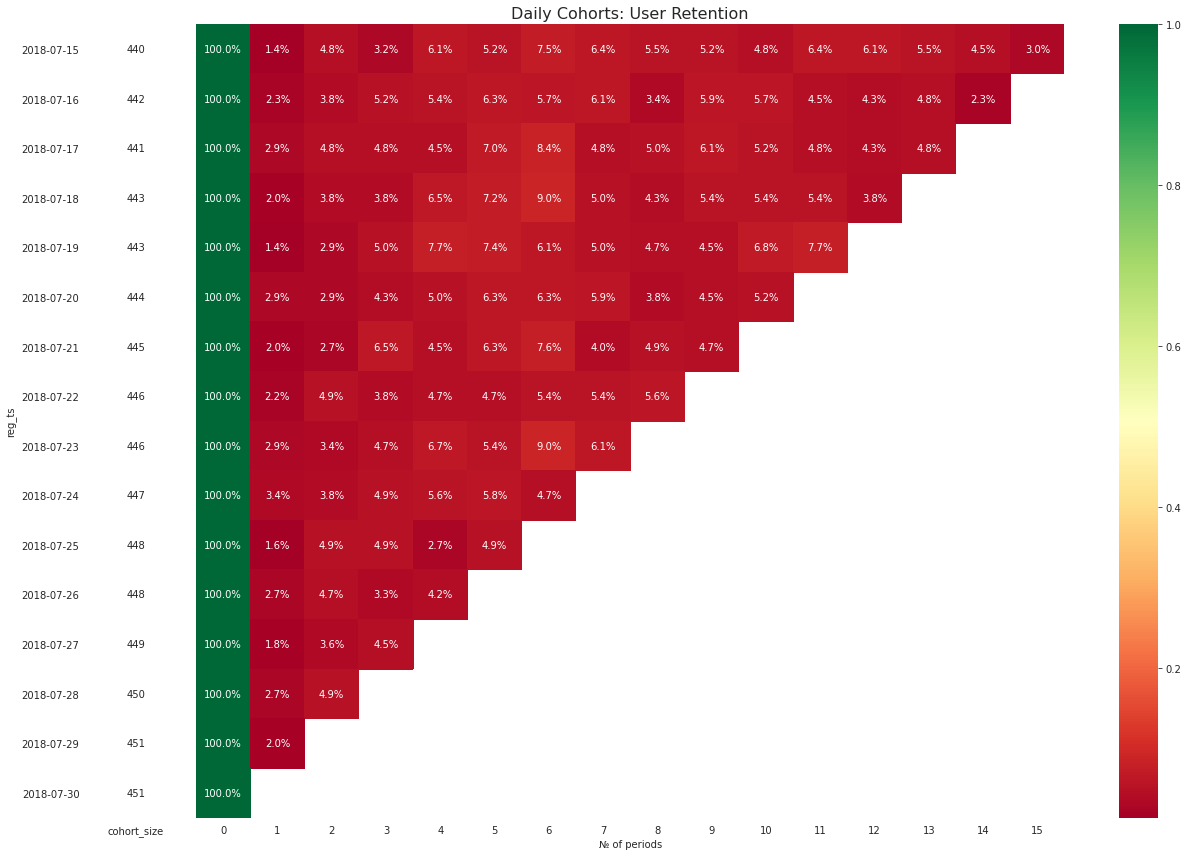

In [3]:
retention('~/shared/problem1-reg_data.csv', '~/shared/problem1-auth_data.csv', '2018-07-15', '2018-07-30')